# Import and Check OS

In [1]:
import sys


import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import scipy.ndimage as nd

In [2]:
def change_contrast_brightness(image, alpha, beta):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def gamma_adjustment(img_original, gamma):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

In [3]:
if 'win32' in sys.platform:
    ex_filepath = 'F:\Colonies_Data\data\plate 2_24.png'
if 'darwin' in sys.platform:
    ex_filepath = "/Volumes/Samsung_T5/Colonies_Data/data/plate 2_24.png"

# Find the plate

## Find position and radius of the plate

In [4]:
# https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
IMG_SIZE = 1000

image = cv2.imread(ex_filepath)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=int(IMG_SIZE/3), dp=2, minRadius=int(IMG_SIZE/3), maxRadius=int(IMG_SIZE/2))
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    x, y, r = circle_[0]


[[525 461 470]]


## Extract the plate

In [9]:
img = Image.open(ex_filepath).convert("RGB").resize((1000,1000))

npImage=np.array(img)
image = change_contrast_brightness(npImage, .8, 10)

# Create same size alpha layer with circle
alpha = Image.new('L', img.size,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([x-r, y-r, x+r, y+r],0,360,fill=255)

# Convert alpha Image to numpy array
npAlpha=np.array(alpha)

# Add alpha layer to RGB
npImage=np.dstack((image,npAlpha))

# Save with alpha
Image.fromarray(npImage).save('result.png')

# Find Small circles

In [10]:
image = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
image2 = cv2.bitwise_not(image[:,:,:3])
output = image2.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=1, dp=2, minRadius=10, maxRadius=25, param2=37)
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circle_:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
    # show the output image
#     cv2.imshow("output", np.hstack([image2, output]))
#     cv2.waitKey(0)

[[705 933  24]
 [703 935  24]
 [699 937  24]
 ...
 [199 771  11]
 [671 941  11]
 [413 971  11]]


In [16]:
def complete_fit(filepath, template, res_img1:str, res_img2:str, threshold=0.5):
    img = cv2.imread(filepath,0)
    img_rgb = cv2.imread(filepath)
    img_rgb2 = img_rgb.copy()
    img_rgb3 = img_rgb.copy()
    template_ = cv2.imread(template, 0)
    w, h = template_.shape[::-1]
    loc = create_init_image(img_rgb, template_, threshold=threshold, res_img=res_img1) 
    matches = list(zip(*loc[::-1]))
    matches = sorted(matches, key=lambda x:x[0])
    unique_locs = find_unique_locs(matches, w, h)
    merged_locs = find_merged_locs(unique_locs, w, h)
    merged_locs = find_merged_locs(merged_locs, w, h)
    create_final_image(img_rgb2, merged_locs, res_img=res_img2)
    colonies = extract_colonies(img_rgb3, merged_locs)
    return colonies

In [14]:
def create_init_image(img_rgb, template, threshold, res_img):
    """
    Creates the initial image, with all matches to the template outlined in red.
    Inputs:
        img_rgb: array of the image to highlight
        template: template subimage to find in img_rgb
        threshold: Threshold for the template matching algorithm
        res_img1: filename to save the resulting image to.
    Returns: None
    """
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    threshold = threshold
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    cv2.imwrite(res_img, img_rgb)
    return loc


def find_unique_locs(matches, w, h):
    """
    Takes all matches to the template and returns a smaller set of boxes with additional space between them.
    Inputs:
        matches: a list of tuples containing a all matches to the template in the image.
    Returns:
        unique_locs: list of tuples containing less-overlapped boundary boxes
    """
    unique_locs = []
    current_loc = matches[0]
    curr_lim = matches[0]
    for i, match in enumerate(matches):
        if ((match[0] < current_loc[0] + w)
            and(match[1] < current_loc[1] + h)
            and(match[0] >= current_loc[0])
                and((match[1] >= current_loc[1] - h) and (match[1] <= current_loc[1] + h))):
            current_lim = match
        else:
            unique_locs.append(
                (current_loc, (current_loc[0] + w, current_loc[1] + h)))
            current_loc = match
            unique_locs.append(
                (current_loc, (current_loc[0] + w, current_loc[1] + h)))
            curr_lim = match
    return unique_locs


def find_merged_locs(unique_locs, w, h):
    """
    Merges overlapping boundary boxes of colonies.
    Inputs: 
        unique_locs: list of tuples containing data about the unique boundary boxes for colonies.
    Returns:
        merged_locs: list of tuples containing data about the boundary boxes for colonies, with 
            nearby boxes merged with one another.
    """
    merged_locs = []
    locs_to_skip = []
    true_unique_locs = unique_locs.copy()
    for location1 in true_unique_locs:
        merge_count = 0
        close_boxes = []
        if location1 in locs_to_skip:
            continue
        for location2 in true_unique_locs:
            if (location1 != location2) and is_close(location1, location2, w, h):
                close_boxes.append(location2)
                locs_to_skip.append(location2)
                if location2 == ((1791, 1854), (1892, 1945)):
                    print(location1)
                merge_count += 1
        if not close_boxes:
            merged_locs.append(location1)
        else:
            farthest_box = find_farthest(location1, close_boxes)
            merged_locs.append(merge_boxes(location1, farthest_box))
    merged_locs = list(set(merged_locs))
    return merged_locs


def create_final_image(img, merged_locs, res_img):
    """
    Creates the final image of the merged boundary boxes around colonies.
    Inputs:
        img: a numpy array of pixel intensities that make up the image.
        merged_locs: set of merged boundary boxes for identified colonies.
        res_img: file name to save resulting image to.
    Returns: None
    """
    for ul in merged_locs:
        upper_left, lower_right = ul[0], ul[1]
        cv2.rectangle(img, upper_left, lower_right, (0, 255, 0), 4)
    cv2.imwrite(res_img, img)


def extract_colonies(img, boxes):
    """
    Gives arrays (to be converted to images) of all found colonies on the dish.
    Inputs:
        img:base image containing colonies.
        boxes: locations of boxes containing colonies.
    Returns:
        colonies: arrays (to be converted to images) containing supposed colonies.
    """
    colonies = []
    for box in boxes:
        y1 = box[0][0]
        x1 = box[0][1]
        y2 = box[1][0]
        x2 = box[1][1]
        sub_image = img[x1:x2+1, y1:y2+1,:]
        colonies.append(sub_image)
    return colonies

def is_close(loc1, loc2, w=100, h=100):
    loc1_f = np.array(loc1[1])
    loc2_f = np.array(loc2[1])
    diag_of_rect = np.sqrt(w ** 2 + h ** 2)
    if np.linalg.norm(loc1_f - loc2_f, 2) <  diag_of_rect:# max(w, h):
        return True
    else:
        return False
    
def merge_boxes(box_1, box_2):
    new_box_x1 = min(box_1[0][0], box_2[0][0])
    new_box_x2 = max(box_1[1][0], box_2[1][0])
    new_box_y1 = min(box_1[0][1], box_2[0][1])
    new_box_y2 = max(box_1[1][1], box_2[1][1])
    new_box = ((new_box_x1, new_box_y1), (new_box_x2, new_box_y2))
    return new_box


def overlap(box_1, box_2):
    x11 = box_1[0][0]
    y11 = box_1[0][1]
    x12 = box_1[1][0]
    y12 = box_1[1][1]
    x21 = box_2[0][0]
    y21 = box_2[0][1]
    x22 = box_2[1][0]
    y22 = box_2[1][1]
    if ((((x21 <= x12) and (x22 >= x12) and (y21 >= y12) and (y22 <= y12))) 
        or ((x21 >= x12) and (x22 <= x12) and (y21 <= y12) and (y22 >= y12))
        or ((x11 >=x21) and (x11 <= x22) and (y11<= y21) and (y12 >= y21))
        or ((x11 >= x21) and (x11 <= x22) and (y11 >= y21) and (y11 <= y22))):
            return True
    else:
        return False
    
    
def find_farthest(box_1, other_boxes):
    dists = []
    for ob in other_boxes:
        box_1_array = np.array(box_1[0])
        ob_array = np.array(ob[0])
        dists.append(np.linalg.norm(box_1_array - ob_array, 2))
    farthest_idx = dists.index(max(dists))
    return other_boxes[farthest_idx]

def find_max_boxes(locs, w, h):
    loc_1 = locs[0]
    loc_2 = locs[1]
    upper_left = (min(loc_1[0], loc_2[0]), max(loc_1[1], loc_2[1]))
    lower_right = (max(loc_1[0], loc_2[0]) , max(loc_1[1], loc_2[1]) - h)
    return (upper_left, lower_right)


### Plate 1

In [335]:
mc12 = complete_fit("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG", 
             "/Volumes/Samsung_T5/Segmentation_Data/Individual_Colonies/VC0395_300mOsm_12_colony.JPG",
             "res_12.png",
             "res_12_count.png", threshold=0.6)

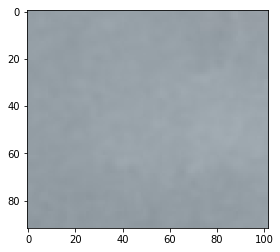

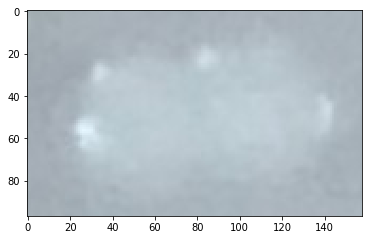

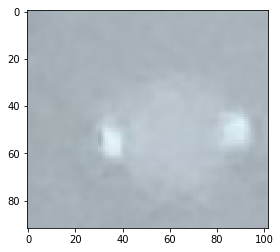

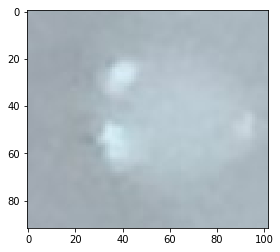

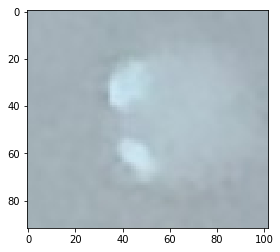

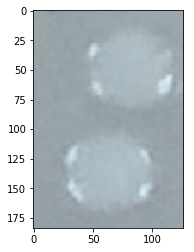

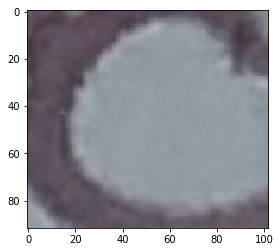

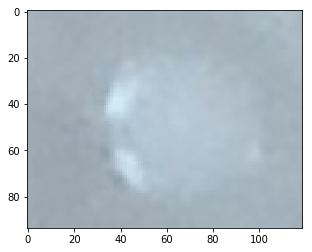

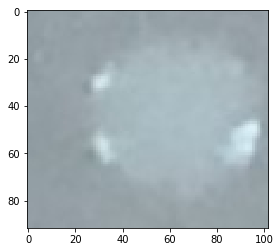

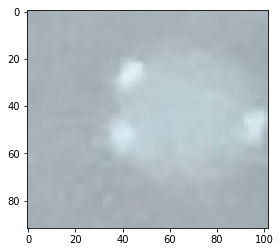

In [336]:
for colony in mc12:
    plt.figure()
    plt.imshow(colony)

### Plate 2

In [288]:
complete_fit("/Volumes/Samsung_T5/Colonies_Data/data/plate 81_50.png", 
             "/Volumes/Samsung_T5/Segmentation_Data/Individual_Colonies/plate 81_50_Colony.png",
             "res_81.png",
             "res_81_count.png", threshold=0.75)

### Plate 3

In [17]:
mc3 = complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/MJF465_400mOsm_37(1).JPG",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/MJF465_400mOsm_37(1)_colony.jpg",
                   "res_37(1).png",
                   "res_37(1)_count.png")

## Attempting Template Matching

In [214]:
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
img = cv2.imread(ex_filepath,0)
img2 = img.copy()
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_Colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = .5
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res_30.png',img_rgb)

True

In [215]:
def is_close(loc1, loc2, w=100, h=100):
    loc1_f = np.array(loc1[1])
    loc2_f = np.array(loc2[1])
    diag_of_rect = np.sqrt(w ** 2 + h ** 2)
    if np.linalg.norm(loc1_f - loc2_f, 2) <  diag_of_rect:# max(w, h):
        return True
    else:
        return False
    
def merge_boxes(box_1, box_2):
    new_box_x1 = min(box_1[0][0], box_2[0][0])
    new_box_x2 = max(box_1[1][0], box_2[1][0])
    new_box_y1 = min(box_1[0][1], box_2[0][1])
    new_box_y2 = max(box_1[1][1], box_2[1][1])
    new_box = ((new_box_x1, new_box_y1), (new_box_x2, new_box_y2))
    return new_box


def overlap(box_1, box_2):
    x11 = box_1[0][0]
    y11 = box_1[0][1]
    x12 = box_1[1][0]
    y12 = box_1[1][1]
    x21 = box_2[0][0]
    y21 = box_2[0][1]
    x22 = box_2[1][0]
    y22 = box_2[1][1]
    if ((((x21 <= x12) and (x22 >= x12) and (y21 >= y12) and (y22 <= y12))) 
        or ((x21 >= x12) and (x22 <= x12) and (y21 <= y12) and (y22 >= y12))
        or ((x11 >=x21) and (x11 <= x22) and (y11<= y21) and (y12 >= y21))
        or ((x11 >= x21) and (x11 <= x22) and (y11 >= y21) and (y11 <= y22))):
            return True
    else:
        return False
    
    
def find_farthest(box_1, other_boxes):
    dists = []
    for ob in other_boxes:
        box_1_array = np.array(box_1[0])
        ob_array = np.array(ob[0])
        dists.append(np.linalg.norm(box_1_array - ob_array, 2))
    farthest_idx = dists.index(max(dists))
    return other_boxes[farthest_idx]

def find_max_boxes(locs, w, h):
    loc_1 = locs[0]
    loc_2 = locs[1]
    upper_left = (min(loc_1[0], loc_2[0]), max(loc_1[1], loc_2[1]))
    lower_right = (max(loc_1[0], loc_2[0]) , max(loc_1[1], loc_2[1]) - h)
    return (upper_left, lower_right)


### Attempting to merge unique_locs

In [216]:
matches = list(zip(*loc[::-1]))
matches = sorted(matches, key=lambda x:x[0])
ul_br_locs = [(match, (match[0] + w, match[1] + h)) for match in matches]

In [197]:
filt = (loc[0] >=2800) * (loc[0] < 3000) * (loc[1] >= 2000) * (loc[1] <=2200)

In [198]:
loc[0]
filtered_list = [i for idx, i in enumerate(zip(*loc[::-1])) if filt[idx]]

#### Attempt 1

In [217]:
problem_colony = [match for match in matches if (match[0] >=2800 and match[0] < 3000 and match[1] >= 2000 and match[1] <=2200)]
unique_locs = []
current_loc = matches[0]
curr_lim = matches[0]
for i, match in enumerate(matches):
    if ((match[0] < current_loc[0] + w) 
        and(match[1] < current_loc[1] + h)
        and(match[0] >= current_loc[0])
        and((match[1] >= current_loc[1] - h) and (match[1] <= current_loc[1] + h))): # Inside curr_loc's box
            current_lim = match
    else:
        if match in filtered_list:
#             print('Problem')
#             print(match)
            print(current_loc)
        unique_locs.append((current_loc, (current_loc[0] + w, current_loc[1] + h)))
        current_loc = match
        unique_locs.append((current_loc, (current_loc[0] + w, current_loc[1] + h)))
        curr_lim = match
        

#### Attempt 2

In [200]:
unique_locs = []
current_loc = matches[0]
curr_lim = matches[0]
for match in matches:
    if ((match[0] < current_loc[0] ) 
        and(match[1] < current_loc[1])
        and(match[0] >= current_loc[0])
        and((match[1] >= current_loc[1] ) and (match[1] <= current_loc[1]))): # Inside curr_loc's box
            current_lim = match
    else:
        unique_locs.append((current_loc, (current_loc[0] + w, current_loc[1] + h)))
        current_loc = match
        curr_lim = match

#### End of Attempt 2

In [233]:
merged_locs = []
locs_to_skip = []
true_unique_locs = unique_locs.copy()
for location1 in true_unique_locs:
    merge_count = 0
    close_boxes = []
    if location1 in locs_to_skip: 
        continue
    for location2 in true_unique_locs:
        if (location1 != location2) and is_close(location1, location2, w, h):
            close_boxes.append(location2)
#             merged_locs.append(merge_boxes(location1, location2))
            locs_to_skip.append(location2)
            if location2 == ((1791, 1854), (1892, 1945)): 
                print(location1)
            merge_count += 1
    if not close_boxes:
        merged_locs.append(location1)
    else:
        farthest_box = find_farthest(location1, close_boxes)
        merged_locs.append(merge_boxes(location1, farthest_box))
merged_locs = list(set(merged_locs))

In [232]:
# template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.60
loc = np.where( res >= threshold)
for ul in merged_locs:
    upper_left, lower_right = ul[0], ul[1]
#     cv2.rectangle(img_rgb, ul[0], (ul[1][0] + w, ul[1][1] + h), (0,0,255), 2)
    cv2.rectangle(img_rgb, upper_left, lower_right, (0,255,0), 4)
# for ul in unique_locs:
#     cv2.rectangle(img_rgb, ul[0], (ul[1][0] , ul[1][1] ), (0,0,255), 2)
    
cv2.imwrite('res2.png',img_rgb)

True

In [297]:
merged_locs

[((775, 2172), (907, 2263)),
 ((1646, 1435), (1825, 1539)),
 ((980, 1329), (1160, 1496)),
 ((1700, 166), (1807, 260)),
 ((2035, 2435), (2162, 2529)),
 ((1601, 2197), (1702, 2288)),
 ((1805, 2790), (1913, 2888)),
 ((700, 1532), (813, 1630)),
 ((677, 3779), (778, 3870)),
 ((1782, 1850), (1913, 1944)),
 ((1427, 867), (1528, 958)),
 ((945, 2701), (1086, 2888)),
 ((1357, 3757), (1458, 3848)),
 ((2006, 639), (2107, 730)),
 ((806, 1043), (908, 1134)),
 ((1382, 1548), (1483, 1639)),
 ((194, 242), (295, 333)),
 ((1278, 1321), (1379, 1412)),
 ((1899, 483), (2050, 583)),
 ((1555, 2820), (1662, 2915)),
 ((1869, 3056), (1970, 3147)),
 ((311, 3398), (412, 3489)),
 ((2047, 221), (2163, 314)),
 ((1693, 2927), (1825, 3022)),
 ((701, 1978), (812, 2076)),
 ((478, 1786), (579, 1877)),
 ((1620, 2506), (1721, 2597)),
 ((2023, 2876), (2157, 2972)),
 ((1913, 881), (2143, 997)),
 ((1696, 3633), (1804, 3725)),
 ((1093, 872), (1194, 963)),
 ((896, 331), (997, 422)),
 ((1551, 1617), (1663, 1710))]

#### Finding Missing Colonies

In [97]:
img_rgb = cv2.imread(ex_filepath)
img_ = img_rgb[2800:3000, 2000:2200]
cv2.imwrite('res3.png', img_ )

True

In [41]:
true_unique_locs

[((711, 1539), (812, 1630)),
 ((785, 2173), (886, 2264)),
 ((958, 2797), (1059, 2888)),
 ((1282, 1320), (1383, 1411)),
 ((1394, 1548), (1495, 1639)),
 ((1662, 1444), (1763, 1535)),
 ((1718, 2927), (1819, 3018)),
 ((1791, 1854), (1892, 1945)),
 ((2021, 900), (2122, 991))]

In [26]:
merged_locs

[((711, 1539), (812, 1630)),
 ((785, 2173), (886, 2264)),
 ((958, 2705), (1084, 2888)),
 ((1282, 1320), (1383, 1411)),
 ((1394, 1548), (1495, 1639)),
 ((1662, 1440), (1818, 1535)),
 ((1662, 1439), (1819, 1535)),
 ((1701, 2927), (1818, 3020)),
 ((1701, 2927), (1819, 3020)),
 ((2021, 900), (2122, 991))]

In [120]:
img = cv2.imread(ex_filepath,0)
img2 = img.copy()
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.6
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

(array([ 898,  898,  898, ..., 2943, 2943, 2943]), array([2023, 2024, 2025, ..., 1715, 1716, 1717]))


True

In [131]:
for ul in unique_locs:
    print(ul)

((711, 1539), (812, 1630))
((785, 2173), (886, 2264))
((958, 2797), (1059, 2888))
((983, 2705), (1084, 2796))
((1282, 1320), (1383, 1411))
((1394, 1548), (1495, 1639))
((1662, 1444), (1763, 1535))
((1701, 2929), (1802, 3020))
((1717, 1440), (1818, 1531))
((1717, 2927), (1818, 3018))
((1718, 1439), (1819, 1530))
((1718, 2927), (1819, 3018))
((1791, 1854), (1892, 1945))
((2021, 900), (2122, 991))


In [264]:
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.55
loc = np.where( res >= threshold)
for ul in true_unique_locs:
    upper_left, lower_right = find_max_boxes(ul, w, h)
#     cv2.rectangle(img_rgb, ul[0], (ul[1][0] + w, ul[1][1] + h), (0,0,255), 2)
    cv2.rectangle(img_rgb, upper_left, lower_right, (0,255,0), 2)

cv2.imwrite('res.png',img_rgb)



True

In [67]:
unique_locs

[((711, 1539), (719, 1542)),
 ((785, 2173), (803, 2174)),
 ((958, 2797), (982, 2721)),
 ((983, 2705), (996, 2715)),
 ((1282, 1320), (1296, 1323)),
 ((1394, 1548), (1416, 1549)),
 ((1662, 1444), (1674, 1447)),
 ((1701, 2929), (1716, 2943)),
 ((1717, 1440), (1716, 2943)),
 ((1717, 2927), (1717, 2943)),
 ((1718, 1439), (1718, 1440)),
 ((1718, 2927), (1723, 2937)),
 ((1791, 1854), (1810, 1856)),
 ((2021, 900), (2032, 908))]

### Trying to merge close colony boxes

In [ ]:
locs_to_remove = []
true_unique_locs = ul_br_locs.copy()
for location1 in true_unique_locs:
    for location2 in true_unique_locs:
        if (location1 != location2) and is_close(location1, location2):
            locs_to_remove.append(location2)

In [257]:
first_box = ul_br_locs[0]
overlapped_boxes = []
for box in ul_br_locs[:5]:
    if overlap(box, first_box):
        overlapped_boxes.append(box)

farthest_box = find_farthest(first_box, overlapped_boxes)
new_box = merge_boxes(first_box, farthest_box)
new_box

((711, 1539), (812, 1632))

In [258]:
ul_br_locs_c = ul_br_locs.copy()
merged_boxes = []
for fb in ul_br_locs_c:
    overlapped_boxes = []
    for box in ul_br_locs_c:
        if overlap(fb, box):
            overlapped_boxes.append(box)
            ul_br_locs_c.remove(box)
    farthest_box = find_farthest(fb, overlapped_boxes)
    new_box = merge_boxes(fb, farthest_box)
    merged_boxes.append(new_box)

In [262]:
len(ul_br_locs)

2423

## Extra Stuff

In [242]:
true_unique_locs

[((711, 1539), (812, 1630)),
 ((785, 2173), (886, 2264)),
 ((958, 2797), (1059, 2888)),
 ((1282, 1320), (1383, 1411)),
 ((1394, 1548), (1495, 1639)),
 ((1662, 1444), (1763, 1535)),
 ((1718, 2927), (1819, 3018)),
 ((1791, 1854), (1892, 1945)),
 ((2021, 900), (2122, 991))]

In [243]:

total_locs = true_unique_locs.copy()
len(total_locs)
locs_to_remove = []
all_locs = []
for ul_1 in total_locs:
    current_close = 0
    for ul_2 in total_locs:
        if is_close(ul_1, ul_2, w, h) and ul_1 != ul_2:
            all_locs.append(find_max_boxes((ul_1[0], ul_2[0]), w, h))
            locs_to_remove.append(ul_1)
            locs_to_remove.append(ul_2)
            current_close += 1
    if not current_close:
        all_locs.append(find_max_boxes(ul_1, w, h))

In [244]:
all_locs = set(all_locs)
all_locs

{((711, 1630), (812, 1539)),
 ((785, 2264), (886, 2173)),
 ((958, 2888), (1059, 2797)),
 ((1282, 1411), (1383, 1320)),
 ((1394, 1639), (1495, 1548)),
 ((1662, 1535), (1763, 1444)),
 ((1718, 3018), (1819, 2927)),
 ((1791, 1945), (1892, 1854)),
 ((2021, 991), (2122, 900))}

In [245]:
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.50
loc = np.where( res >= threshold)
for ul in all_locs:
    upper_left, lower_right = ul[0], ul[1]
#     cv2.rectangle(img_rgb, ul[0], (ul[1][0] + w, ul[1][1] + h), (0,0,255), 2)
    cv2.rectangle(img_rgb, upper_left, lower_right, (0,255,0), 2)

cv2.imwrite('res2.png',img_rgb)

True